# Basis Recognition (Symbol-Supervised Model)

### Imports

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, minmax_scale
import torch.nn as nn
from Data_reading import*
import torch.optim as optim

### Data Dawnload and Scaling

In [4]:
x = Symbol('x')

support = support_reading()
X_lin, Y_complexity_lin, GT_function_lin ,labels_one_hot_lin = read_data(
    support, dir = r"C:\Users\lbg\OneDrive - CSEM S.A\Bureau\Pytorch\NEW_EQ_LEARN\Data\Linear")

X_lin_ = minmax_scale(X_lin,axis = 1)

X_lin_train, labels_one_hot_lin_train, GT_function_lin_train = X_lin_[:8000], labels_one_hot_lin[:8000,:-1], GT_function_lin[:8000]
X_lin_test, labels_one_hot_lin_test, GT_function_lin_test = X_lin_[8000:], labels_one_hot_lin[8000:,:-1], GT_function_lin[8000:]

X_lin_train_, labels_one_hot_lin_train, GT_function_lin_train = X_lin[:8000], labels_one_hot_lin[:8000,:-1], GT_function_lin[:8000]
X_lin_test_, labels_one_hot_lin_test, GT_function_lin_test = X_lin[8000:], labels_one_hot_lin[8000:,:-1], GT_function_lin[8000:]


labels_one_hot_lin_train.shape

(8000, 7)

### Dataset Iterator Class

In [5]:
class dataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, dataset,  labels, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataset = dataset
        self.transform = transform
        self.label = labels

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        data = self.dataset[idx, :].astype('float32')
        label1 = self.label[idx, :]
        data = torch.from_numpy(np.reshape(data,[self.dataset.shape[1]]))
        label1 = torch.from_numpy((np.reshape(np.array(label1),[7]).astype('float32')))

        if self.transform:
            data = self.transform(data)

        return data,label1


### Train-Validation Split

In [6]:
dataset_train = dataset(X_lin_train, labels_one_hot_lin_train)
dataset_test_h = dataset(X_lin_test, labels_one_hot_lin_test)
batch_size = 100


valid_size = 0.20
num_train = len(dataset_train)
num_test_h = len(dataset_test_h)
indices = list(range(num_train))
test_idx_h = list(range(num_test_h))
np.random.shuffle(test_idx_h)
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler_h = SubsetRandomSampler(test_idx_h)


train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
    sampler=train_sampler, num_workers=0)
valid_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=0)
test_loader_h = torch.utils.data.DataLoader(dataset_test_h, batch_size=batch_size, 
    sampler=test_sampler_h, num_workers=0)

### Network Model

In [7]:
class Net(nn.Module):
    def __init__(self,H):
        super(Net, self).__init__()
        self.H = H
        self.layer1 = torch.nn.Linear(998, self.H)
        self.layer2 = torch.nn.ReLU()
        self.layer3 = nn.Dropout(0.3) 
        self.layer4 = torch.nn.Linear(self.H, self.H)
        self.layer5 = torch.nn.ReLU()
        self.layer6 = nn.Dropout(0.3)
        self.layer7 = torch.nn.Linear(self.H, self.H)
        self.layer8 = torch.nn.ReLU()
        self.layer9 = nn.Dropout(0.3) 
        self.layer10 = torch.nn.Linear(self.H, self.H)
        self.layer11 = torch.nn.ReLU()
        self.layer12 = nn.Dropout(0.3) 
        self.layersf = torch.nn.Linear(self.H, 7)
        self.layersff = torch.nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layersf(x)
        x = self.layersff(x)
        return x



### Training

In [8]:
# create a complete NN
model = Net(500)
model.float()
print(model)

criterion = nn.MSELoss(reduction='mean')

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 0)

# number of epochs to train the model
n_epochs = 100



# track change in validation loss
valid_loss_min = np.Inf 


print('Do you want to retrain the model?')
resp = input()
if resp == 'yes':
    print('Do you want to save the model parameters?')
    save = input()
    for epoch in range(1, n_epochs+1):

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        for data, target in train_loader:
            # move tensors to GPU if CUDA is available
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)


        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            #_, pred = torch.max(output, 1)   
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)

        # calculate average losses
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)


        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        
        if save == 'yes':
            # save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
                torch.save(model.state_dict(), r"C:\Users\lbg\OneDrive - CSEM S.A\Bureau\Pytorch\NEW_EQ_LEARN\Saved_Models\FF1_Linear.pt")
                valid_loss_min = valid_loss
else:
    print('Model not trained')
    pass

Net(
  (layer1): Linear(in_features=998, out_features=500, bias=True)
  (layer2): ReLU()
  (layer3): Dropout(p=0.3, inplace=False)
  (layer4): Linear(in_features=500, out_features=500, bias=True)
  (layer5): ReLU()
  (layer6): Dropout(p=0.3, inplace=False)
  (layer7): Linear(in_features=500, out_features=500, bias=True)
  (layer8): ReLU()
  (layer9): Dropout(p=0.3, inplace=False)
  (layer10): Linear(in_features=500, out_features=500, bias=True)
  (layer11): ReLU()
  (layer12): Dropout(p=0.3, inplace=False)
  (layersf): Linear(in_features=500, out_features=7, bias=True)
  (layersff): ReLU()
)
Do you want to retrain the model?
yes
Do you want to save the model parameters?
yes
Epoch: 1 	Training Loss: 0.142116 	Validation Loss: 0.111518
Validation loss decreased (inf --> 0.111518).  Saving model ...
Epoch: 2 	Training Loss: 0.109606 	Validation Loss: 0.097894
Validation loss decreased (0.111518 --> 0.097894).  Saving model ...
Epoch: 3 	Training Loss: 0.101675 	Validation Loss: 0.092570
V

Epoch: 93 	Training Loss: 0.058887 	Validation Loss: 0.048195
Validation loss decreased (0.048886 --> 0.048195).  Saving model ...
Epoch: 94 	Training Loss: 0.060484 	Validation Loss: 0.055087
Epoch: 95 	Training Loss: 0.063307 	Validation Loss: 0.054572
Epoch: 96 	Training Loss: 0.060571 	Validation Loss: 0.052320
Epoch: 97 	Training Loss: 0.060797 	Validation Loss: 0.055865
Epoch: 98 	Training Loss: 0.059173 	Validation Loss: 0.048083
Validation loss decreased (0.048195 --> 0.048083).  Saving model ...
Epoch: 99 	Training Loss: 0.061313 	Validation Loss: 0.047225
Validation loss decreased (0.048083 --> 0.047225).  Saving model ...
Epoch: 100 	Training Loss: 0.058541 	Validation Loss: 0.047411


### Load Model and Evaluate it

In [58]:
model.eval()
model.load_state_dict(torch.load(r"C:\Users\lbg\OneDrive - CSEM S.A\Bureau\Pytorch\NEW_EQ_LEARN\Saved_Models\FF1_Linear.pt"))
Y_hat_test = model(torch.from_numpy(X_lin_test.astype('float32')))
Y_hat_val = model(torch.from_numpy(X_lin_train[valid_idx].astype('float32')))
Y_hat_tr = model(torch.from_numpy(X_lin_train[train_idx].astype('float32')))
Y_hat_train = model(torch.from_numpy(X_lin_train.astype('float32')))

In [59]:
x = Symbol('x')
basis_functions = np.array([sin(x),exp(x), x, exp(-x), 1/x, sin(x**2), exp(-x**2),1])
yb = torch.Tensor([[lambdify(x,basis_functions[j])(i) for i in support] for j in range(len(basis_functions)-1)])

14.6536529437856*x + 1.81048856141964*sin(x) + 2.69982573955041*exp(-x**2)
[ 1.7917472  0.        14.651634   0.         0.         0.
  0.       ]


<IPython.core.display.Javascript object>


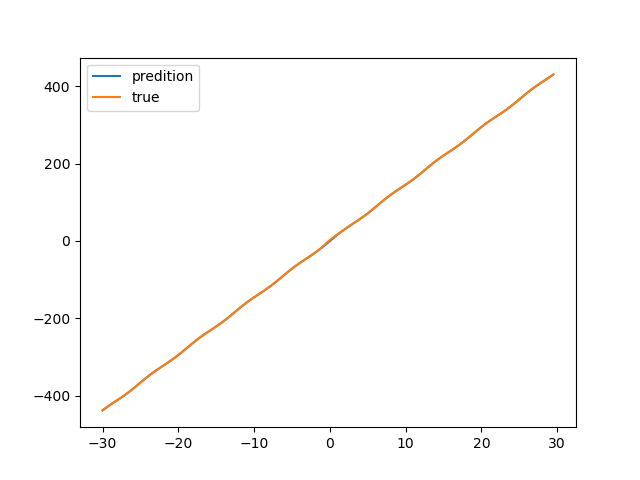

In [207]:
ys = torch.unsqueeze(torch.Tensor(X_lin_train_[:,0::200]),2)[:100]
xd = torch.eye(7)
xd = xd.reshape((1, 7, 7))
y = xd.repeat(100, 1, 1)
a = torch.nn.Threshold(0.5,0)
yy = a(Y_hat_train[:100])
s = torch.unsqueeze(yy,1)
q = s*y
c = torch.bmm(torch.unsqueeze(yb[:,0::200].T,0).repeat(100,1,1),q)
d = torch.bmm(torch.transpose(c,1,2),c) + 0.001*torch.eye(7)
e = torch.inverse(d)
f = torch.bmm(e,torch.transpose(c,1,2))



sp = 26
ss = np.arange(-30,30,5e-1)
print(GT_function_lin_train[sp])
print(torch.bmm(f,ys)[sp].detach().numpy()[:,0]*yy[sp].detach().numpy())


wa = np.dot(torch.bmm(f,ys)[sp].detach().numpy()[:,0]*yy[sp].detach().numpy(), basis_functions[:-1])
y_test = [lambdify(x,wa)(i) for i in ss]
y_true = [lambdify(x,GT_function_lin_train[sp])(i) for i in ss]


%matplotlib notebook
plt.plot(ss,y_test, label = 'predition')
plt.plot(ss,y_true, label = 'true')
plt.legend()

0.63612629605575*sin(x) + 5.04996583357689*sin(x**2)
[[ 0.42298943]
 [ 0.02949607]
 [-0.16779533]
 [-0.00451853]
 [ 0.34722492]
 [ 4.252823  ]
 [ 1.8212692 ]]


<lambdifygenerated-52219>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (-0.167795330286026*x + 0.0294960662722588*exp(x) + 0.422989428043365*sin(x) + 4.25282287597656*sin(x**2) + 1.82126915454865*exp(-x**2) - 0.0045185312628746*exp(-x) + 0.347224920988083/x)


<IPython.core.display.Javascript object>


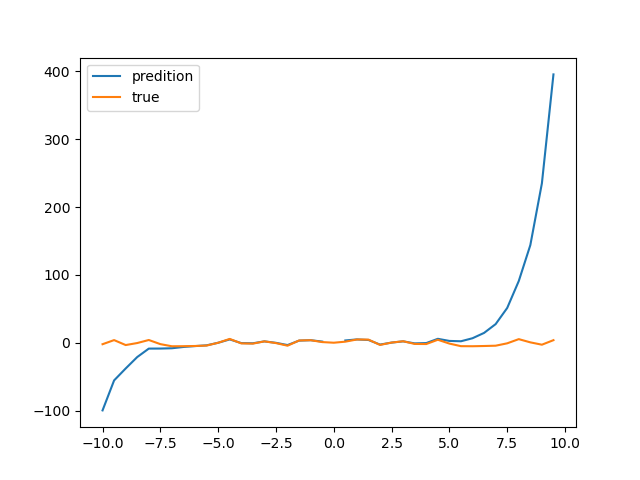

In [203]:
ys = torch.unsqueeze(torch.Tensor(X_lin_train_[:,0::200]),2)[:10]
c = torch.unsqueeze(yb[:,0::200].T,0).repeat(10,1,1)
d = torch.bmm(torch.transpose(c,1,2),c) + 0.001*torch.eye(7)
e = torch.inverse(d)
f = torch.bmm(e,torch.transpose(c,1,2))


sp = 0
ss = np.arange(-10,10,5e-1)
print(GT_function_lin_train[sp])
print(torch.bmm(f,ys)[sp].detach().numpy())


wa = np.dot(torch.bmm(f,ys)[sp].detach().numpy()[:,0], basis_functions[:-1])
y_test = [lambdify(x,wa)(i) for i in ss]
y_true = [lambdify(x,GT_function_lin_train[sp])(i) for i in ss]


%matplotlib notebook
plt.plot(ss,y_test, label = 'predition')
plt.plot(ss,y_true, label = 'true')
plt.legend()

### Look at  perfromances

Overall Accuracy
0.687656171914043
0.6953750000000001

True Equation:
0.63612629605575*sin(x) + 5.04996583357689*sin(x**2)

Prediction
[1 0 0 0 0 1 0]

Ground Truth
[1. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


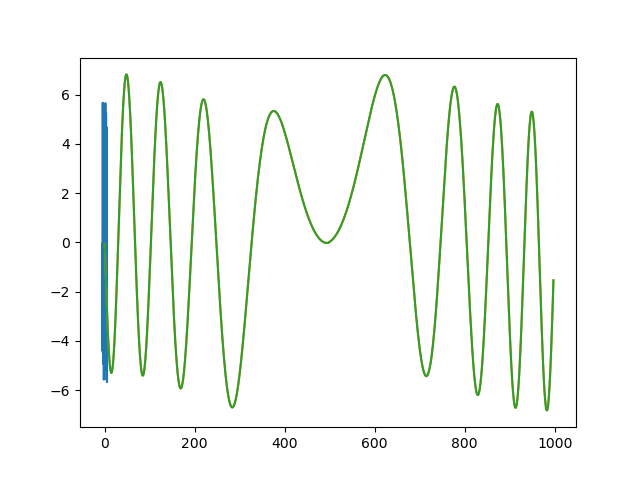

In [111]:
#15,150,120,190,51,173
%matplotlib notebook

temp = Y_hat_test>0.5
Y_hat_test = temp.numpy().astype(int)
temp = Y_hat_train>0.5
Y_hat_train = temp.numpy().astype(int)

print('Overall Accuracy')
print(1-sum([False in (labels_one_hot_lin_test[i] == Y_hat_test[i]) for i in range(len(Y_hat_test))])/len(Y_hat_test))
print(1-sum([False in (labels_one_hot_lin_train[i] == Y_hat_train[i]) for i in range(len(Y_hat_train))])/len(Y_hat_train))
print()

basis_functions = np.array([sin(x),exp(x), x, exp(-x), 1/x, sin(x**2), exp(-x**2),1])
sample = 0
print('True Equation:')
print(GT_function_lin_train[sample])
print()
print('Prediction')
print(Y_hat_train[sample])
print()
print('Ground Truth')
print(labels_one_hot_lin_train[sample])
y = [lambdify(x,GT_function_lin_train[sample])(i) for i in support]
plt.plot(support,y)

<IPython.core.display.Javascript object>


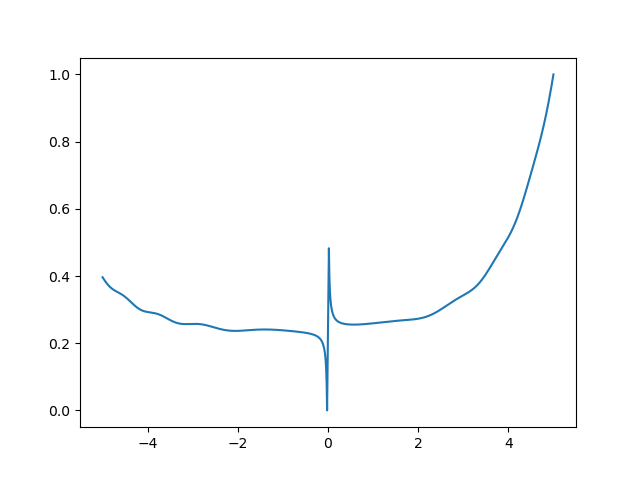

In [66]:
%matplotlib notebook
plt.plot(support,X_lin_test[sample])

### Single-basis Performance

In [63]:
print('Test Set')
for i in range(7):
    print(sum(labels_one_hot_lin_test[:,i] == Y_hat_test[:,i])/len(Y_hat_test))

print()    
    

print('Training Set')    
for i in range(7):
    print(sum(labels_one_hot_lin_train[:,i] == Y_hat_train[:,i])/len(Y_hat_train))

Test Set
0.9055472263868066
0.9945027486256871
0.9525237381309345
0.9950024987506247
0.9905047476261869
0.9005497251374313
0.8500749625187406

Training Set
0.9065
0.996125
0.951875
0.995625
0.99025
0.90625
0.861625


### Confusion Matrix

In [11]:
from sklearn.metrics import multilabel_confusion_matrix
sums = [sum(labels_one_hot_lin_test[:,i]) for i in range(8)]
confusion = multilabel_confusion_matrix(labels_one_hot_lin_test, Y_hat_test)
for i in range(8):
    print(confusion[i]/sums[i])
    print()


[[2.1140625 0.0125   ]
 [0.3546875 0.6453125]]

[[2.2170418  0.        ]
 [0.02733119 0.97266881]]

[[1.99250375 0.00749625]
 [0.16641679 0.83358321]]

[[2.08320493 0.        ]
 [0.02157165 0.97842835]]

[[2.18124006 0.        ]
 [0.03338633 0.96661367]]

[[2.35738255 0.        ]
 [0.20134228 0.79865772]]

[[2.12168487 0.        ]
 [0.44617785 0.55382215]]

[[2.13636364 0.        ]
 [0.9153605  0.0846395 ]]

